In [40]:
# we want to test whether we can do
# a- adding phase terms
# b- adding simulatenous 1q gates during the 2q gates 
# we know that adding these terms won't change the unitary in the weyl space
# but we want to eliminate the 1q gates to minimize the overall duration
# so although it doesn't change in the weyl space, it does change the actual unitary
# its possible that these changes mean that the 1q gates are no longer needed 
# for example, the same 2Q hamiltonian can make both the CX and CZ gate directly
# the additional benefit is that these are changes on top of the originally calibrated gate
# so they don't have to be recabibrated - we calibrate 1 point in the weyl chamber and get for free the different version of the gate

# the benefit to be clear is that small 2Q gates require more applications, and the benefit diminshes when we need much more 1Q gates
# if we don't need to count 1Q gates using this method the benefit from smaller 2Q is significantly large

In [41]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import numpy as np

%matplotlib widget

In [42]:
from slam.hamiltonian import ConversionGainPhaseHamiltonian
from slam.basisv2 import CircuitTemplateV2
from slam.utils.gates.custom_gates import ConversionGainGate
pp =lambda p1, p2: ConversionGainGate(p1, p2, np.pi/4, np.pi/4)
basis = CircuitTemplateV2(n_qubits=2, base_gates=[pp], no_exterior_1q=0, vz_only=1)
basis.build(1)

In [43]:
basis.spanning_range = range(1,2)
basis.circuit.draw()

┌────────┐┌──────────────────────────┐┌────────┐
q_0: ┤ Rz(P0) ├┤0                         ├┤ Rz(P2) ├
     ├────────┤│  2qgate(Q0,Q1,π/4,π/4,1) │├────────┤
q_1: ┤ Rz(P1) ├┤1                         ├┤ Rz(P3) ├
     └────────┘└──────────────────────────┘└────────┘

In [44]:
from slam.cost_function import MutualInformation, MutualInformationSquare, BasicCostInverse, BasicCost, BasicReducedCost
#objective = MutualInformation(state='w')
unitary_objective = BasicCost() #Inverse()
from slam.optimizer import TemplateOptimizer
#optimizer = TemplateOptimizer(basis=basis, objective=objective, use_callback=True, override_fail=True)
optimizer = TemplateOptimizer(basis=basis, objective=unitary_objective, use_callback=False, override_fail=True, training_restarts=15)

In [45]:
from slam.sampler import HaarSample, GateSample
#sampler = HaarSample(seed=0,n_samples=1) #don't care
from qiskit.circuit.library import CXGate, CZGate
#sampler = GateSample(gate = CXGate())
sampler = GateSample(gate = CZGate())
s = [s for s in sampler][0]
ret = optimizer.approximate_target_U(s)

INFO:root:Begin search: (0.5, 0.0, 0.0)
INFO:root:Starting opt on template size 1
100%|██████████| 15/15 [00:06<00:00,  2.25it/s]
INFO:root:Loss=0.5000000000000001
INFO:root:Fail: (0.5, 0.0, 0.0), Alternative: (0.5, 0.0, 0.0)


In [46]:
#show the result of training
basis.build(ret.cycles)
circuit =basis.assign_Xk(ret.Xk)
print("Fidelity", ret.loss_result)
print("duration cost:", basis.circuit_cost(ret.Xk))
circuit.draw()

Fidelity 0.5000000000000001
duration cost: 0.0


┌──────────────────────┐ »
q_0: ─┤ Rz(7.99619237371622) ├─»
     ┌┴──────────────────────┴┐»
q_1: ┤ Rz(-0.335206958125518) ├»
     └────────────────────────┘»
«     ┌────────────────────────────────────────────────────────┐»
«q_0: ┤0                                                       ├»
«     │  2qgate(-0.48757119084371,-8.69206801170595,π/4,π/4,1) │»
«q_1: ┤1                                                       ├»
«     └────────────────────────────────────────────────────────┘»
«     ┌──────────────────────┐
«q_0: ┤ Rz(2.99938186607118) ├
«     ├──────────────────────┤
«q_1: ┤ Rz(11.3307812281878) ├
«     └──────────────────────┘

In [47]:
from slam.utils.gates.custom_gates import ConversionGainSmushGate
t = 0.1
duration_1q = 0.05
# NOTE first variable is tracking an offset (basically set it to 2 if counting the phase variables)
p_expand = [0, round(t/duration_1q), round(t/duration_1q)]
# XXX turn p_expand into indices is tricky

#pp2 =lambda *vargs: ConversionGainSmushGate(vargs[0], vargs[1], np.pi/2, 0, vargs[2:2+round(t/duration_1q)], vargs[2+round(t/duration_1q):], t_el=t)
pp2 =lambda *vargs: ConversionGainSmushGate(0, 0, np.pi/2, 0, vargs[:round(t/duration_1q)], vargs[round(t/duration_1q):], t_el=t)
#pp2 =lambda *vargs: ConversionGainSmushGate(0,0, vargs[0], vargs[1], vargs[2:2+round(t/duration_1q)], vargs[2+round(t/duration_1q):], t_el=t)

# circuittemplate builds # of parameters by checking the number of parameters in the lambda function to build the gate
# because the parametes for gx and gy are vectors they only get counted once and it messes up
# we can add an extra parameter called param_vec_expand
# we need to use this to tell it to expand the number of parameters we should include
# however, this will get really messy because we don't know which parameters are the vectors or not
# be careful, this is going to be a mess :(
basis = CircuitTemplateV2(n_qubits=2, base_gates=[pp2], no_exterior_1q=0, vz_only=1, param_vec_expand = p_expand)
basis.build(1)

In [48]:
basis.spanning_range = range(1,2)
basis.circuit.draw()

┌────────┐┌────────────────────────────────────┐┌────────┐
q_0: ┤ Rz(P0) ├┤0                                   ├┤ Rz(P2) ├
     ├────────┤│  2qgate(0,0,π/2,0,Q0,Q1,Q2,Q3,0.1) │├────────┤
q_1: ┤ Rz(P1) ├┤1                                   ├┤ Rz(P3) ├
     └────────┘└────────────────────────────────────┘└────────┘

In [49]:
[str(el) for el in basis.circuit.parameters]
for el in basis.circuit.parameters:
    s_el = str(el)
    if 'Q' in s_el:
        basis.add_bound(s_el, 4*np.pi, 0)
#basis.add_bound("Q0", 4*np.pi, 0)

In [50]:
from slam.cost_function import MutualInformation, MutualInformationSquare, BasicCostInverse, BasicCost, BasicReducedCost, SquareCost
#objective = MutualInformation(state='w')
unitary_objective = BasicCost()
from slam.optimizer import TemplateOptimizer
#optimizer = TemplateOptimizer(basis=basis, objective=objective, use_callback=True, override_fail=True)
optimizer = TemplateOptimizer(basis=basis, objective=unitary_objective, use_callback=False, override_fail=True, training_restarts=5)

In [51]:
from qiskit import QuantumCircuit
target = QuantumCircuit(2)
target.append(ConversionGainGate(0,0, np.pi/2, 0, t_el=t), [0,1])
target.h(0)
target.y(0)
target.h(1)
target.x(1)
target.draw()

┌────────────────────────┐┌───┐┌───┐
q_0: ┤0                       ├┤ H ├┤ Y ├
     │  2qgate(0,0,π/2,0,0.1) │├───┤├───┤
q_1: ┤1                       ├┤ H ├┤ X ├
     └────────────────────────┘└───┘└───┘

In [52]:
from slam.sampler import HaarSample, GateSample
#sampler = HaarSample(seed=0,n_samples=1) #don't care
from qiskit.circuit.library import CXGate, CZGate, SwapGate
#sampler = GateSample(gate = CZGate())
#sampler = GateSample(gate = CZGate())
sampler = GateSample(gate = target)
s = [s for s in sampler][0]
ret = optimizer.approximate_target_U(s)

INFO:root:Begin search: (0.05, 0.05, 0.0)
INFO:root:Starting opt on template size 1
100%|██████████| 5/5 [00:38<00:00,  7.79s/it]
INFO:root:Loss=0.0010506251696715818
INFO:root:Fail: (0.05, 0.05, 0.0), Alternative: (0.95, 0.04052791, 0.00947209)


Fidelity 0.0010506251696715818


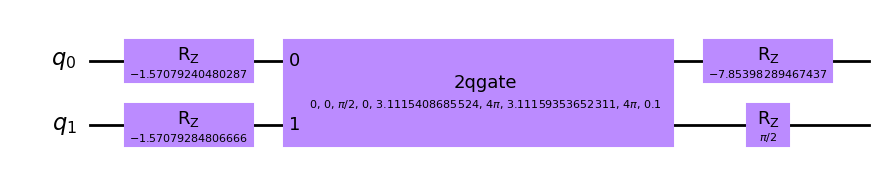

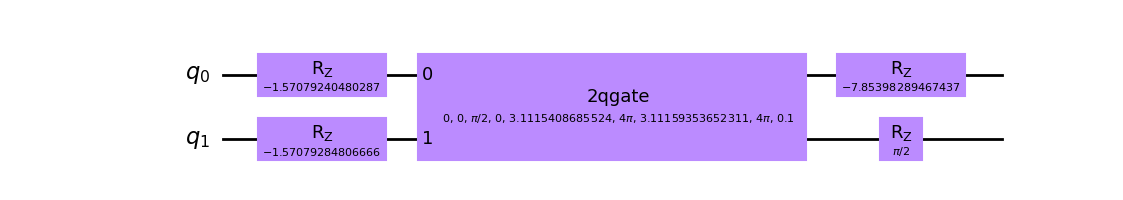

In [53]:
#show the result of training
basis.build(ret.cycles)
circuit =basis.assign_Xk(ret.Xk)    
print("Fidelity", ret.loss_result)
# print("duration cost:", basis.circuit_cost(ret.Xk))
circuit.draw(output='mpl')